### Fast Food Marketing Campaign - A/B Test
###### [Mission] evaluating A/B testing and decide which marketing strategy works the best<br>[Data]<br>data: features for markets

### Prepare data

In [82]:
# base
import pandas as pd
import numpy as np

# visualization
%matplotlib inline
import matplotlib.pyplot as plt

# analysis
import statsmodels.stats.api as sms
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu, f_oneway, kruskal
from statsmodels.stats.multicomp import MultiComparison

# acquire data
data = pd.read_csv('C:/Users/1004/git/kaggle/Fast Food/WA_Marketing-Campaign.csv')

In [83]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MarketID          548 non-null    int64  
 1   MarketSize        548 non-null    object 
 2   LocationID        548 non-null    int64  
 3   AgeOfStore        548 non-null    int64  
 4   Promotion         548 non-null    int64  
 5   week              548 non-null    int64  
 6   SalesInThousands  548 non-null    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 30.1+ KB


In [84]:
df = data.copy()

In [85]:
df.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


<h6>
* Note<br>
Promotion: one of three promotions that were tested<br>
week: one of four weeks when the promotions were run
</h6>

In [86]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
MarketID,548.0,5.715328,2.877001,1.00,3.000,6.0,8.0000,10.00
LocationID,548.0,479.656934,287.973679,1.00,216.000,504.0,708.0000,920.00
AgeOfStore,548.0,8.503650,6.638345,1.00,4.000,7.0,12.0000,28.00
Promotion,548.0,2.029197,0.810729,1.00,1.000,2.0,3.0000,3.00
week,548.0,2.500000,1.119055,1.00,1.750,2.5,3.2500,4.00
SalesInThousands,548.0,53.466204,16.755216,17.34,42.545,50.2,60.4775,99.65


### Anova analysis

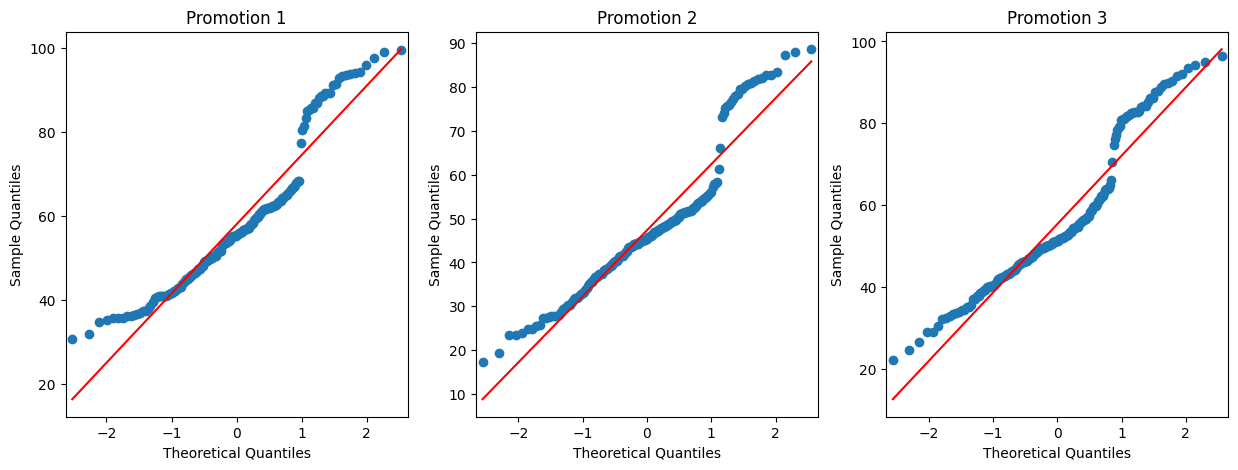

In [87]:
fig, axs = plt.subplots(1, 3, figsize = (15, 5))

qqplot(np.array(df.loc[(df["Promotion"] == 1), "SalesInThousands"]), line = "s", ax = axs[0])
qqplot(np.array(df.loc[(df["Promotion"] == 2), "SalesInThousands"]), line = "s", ax = axs[1])
qqplot(np.array(df.loc[(df["Promotion"] == 3), "SalesInThousands"]), line = "s", ax = axs[2])

axs[0].set_title("Promotion 1")
axs[1].set_title("Promotion 2")
axs[2].set_title("Promotion 3")

plt.show()

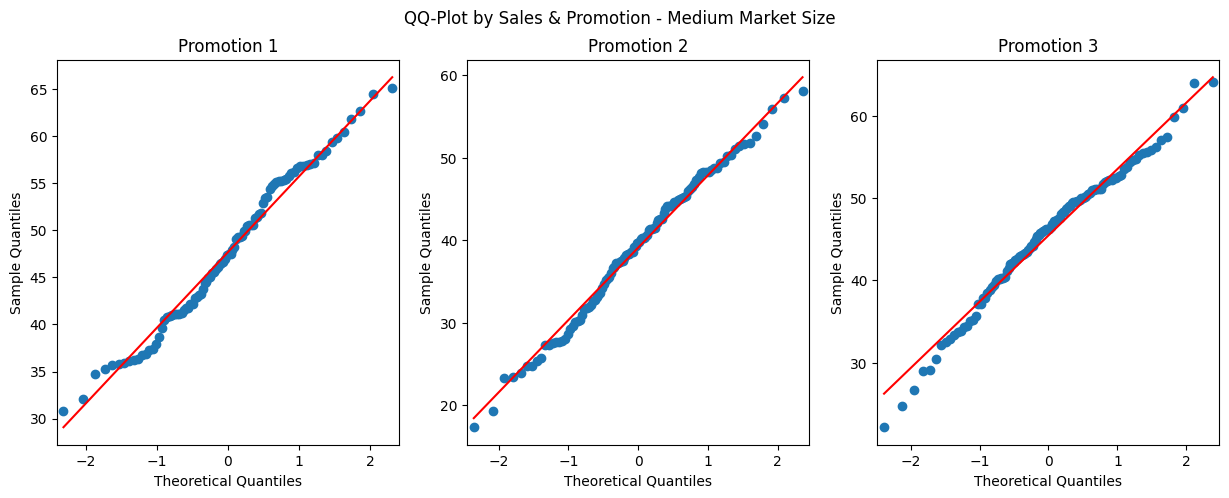

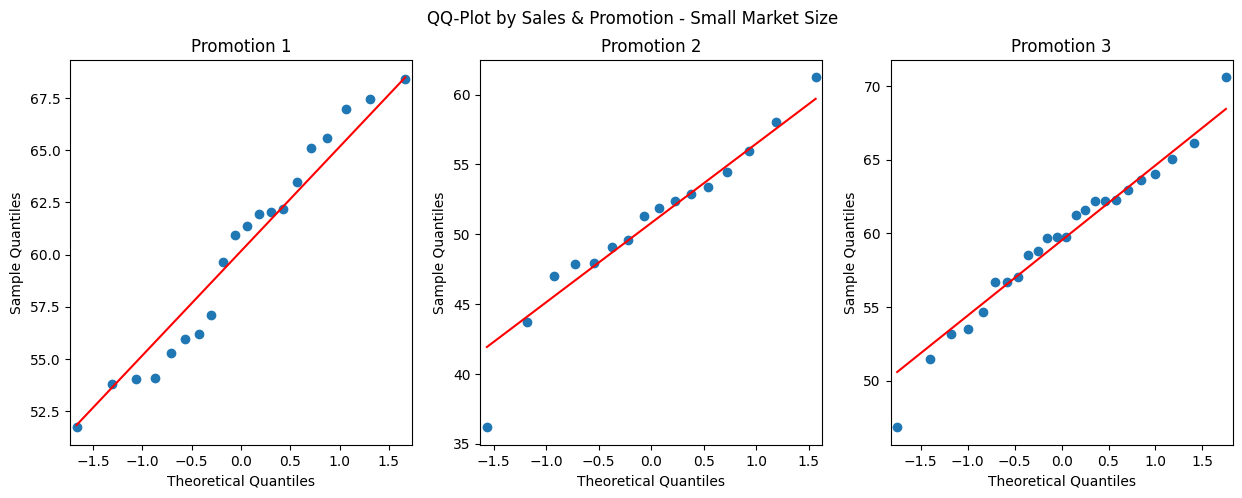

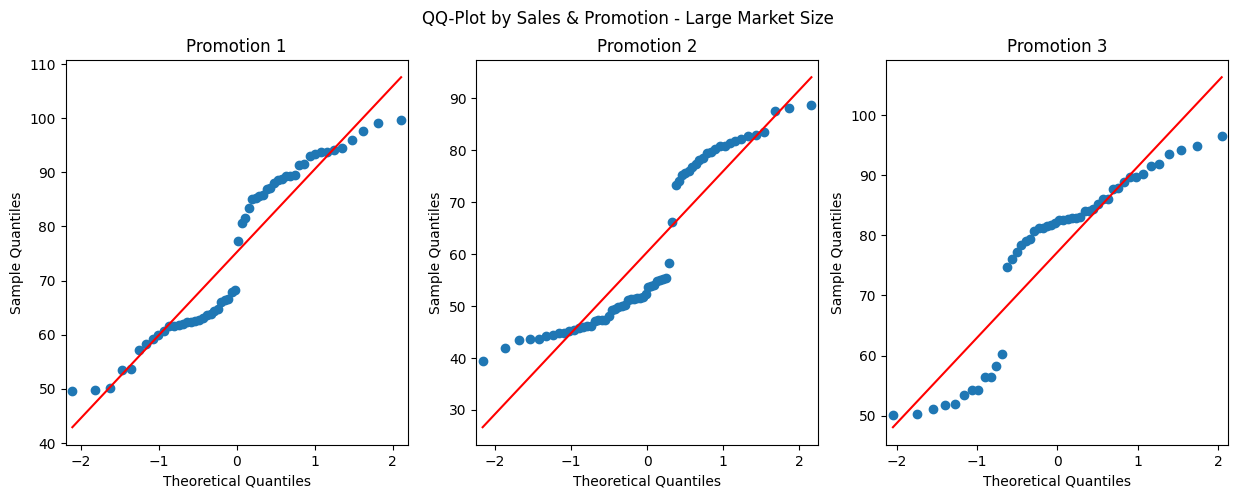

In [88]:
market_size = df["MarketSize"].unique()

for market_size in market_size:
    fig, axs = plt.subplots(1, 3, figsize = (15, 5))
    qqplot(np.array(df.loc[(df["Promotion"] == 1) & (df["MarketSize"] == market_size), "SalesInThousands"]), line = "s", ax = axs[0])
    qqplot(np.array(df.loc[(df["Promotion"] == 2) & (df["MarketSize"] == market_size), "SalesInThousands"]), line = "s", ax = axs[1])
    qqplot(np.array(df.loc[(df["Promotion"] == 3) & (df["MarketSize"] == market_size), "SalesInThousands"]), line = "s", ax = axs[2])   

    axs[0].set_title("Promotion 1")
    axs[1].set_title("Promotion 2")
    axs[2].set_title("Promotion 3")

    fig.suptitle(f"QQ-Plot by Sales & Promotion - {market_size} Market Size")
    plt.show()

In [89]:
# 1) normality - shapiro wilk test
for promotion in list(df["Promotion"].unique()):
    pvalue = shapiro(df.loc[df["Promotion"] == promotion, "SalesInThousands"])[1]
    print("Promotion: ", promotion, "p-value: %.4f" % (pvalue))

Promotion:  3 p-value: 0.0000
Promotion:  2 p-value: 0.0000
Promotion:  1 p-value: 0.0000


In [90]:
# 2) variance homogeneity - levene test
test_stat, pvalue = levene(df.loc[df["Promotion"] == 1, "SalesInThousands"], df.loc[df["Promotion"] == 2, "SalesInThousands"], df.loc[df["Promotion"] == 3, "SalesInThousands"])

print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

Test Stat = 1.2697, p-value = 0.2818


In [91]:
df.groupby("Promotion").agg({"SalesInThousands":["count", "mean", "median"]})

SalesInThousands                   
                     count       mean  median
Promotion                                    
1                      172  58.099012  55.385
2                      188  47.329415  45.385
3                      188  55.364468  51.165

In [92]:
df.groupby(["MarketSize", "Promotion"]).agg({"SalesInThousands":["count", "mean", "median"]})

SalesInThousands                   
                                count       mean  median
MarketSize Promotion                                    
Large      1                       56  75.235893  72.835
           2                       64  60.322031  53.010
           3                       48  77.203958  82.345
Medium     1                       96  47.672604  47.425
           2                      108  39.114352  39.765
           3                      116  45.468879  46.295
Small      1                       20  60.162500  61.145
           2                       16  50.810625  51.600
           3                       24  59.514167  59.745

In [93]:
# 3) nonparametric anova test - kruskal wallis
test_stat, pvalue = kruskal(df.loc[df["Promotion"] == 1, "SalesInThousands"],
                            df.loc[df["Promotion"] == 2, "SalesInThousands"],
                            df.loc[df["Promotion"] == 3, "SalesInThousands"])

print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

Test Stat = 53.2948, p-value = 0.0000


In [94]:
# 4) tukey test
comparison = MultiComparison(df["SalesInThousands"], df["Promotion"])
tukey = comparison.tukeyhsd(0.05)
print(tukey)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     1      2 -10.7696    0.0 -14.7738 -6.7654   True
     1      3  -2.7345 0.2444  -6.7388  1.2697  False
     2      3   8.0351    0.0   4.1208 11.9493   True
-----------------------------------------------------


In [95]:
df.groupby("Promotion").agg({"SalesInThousands":["count", "mean", "median"]})

SalesInThousands                   
                     count       mean  median
Promotion                                    
1                      172  58.099012  55.385
2                      188  47.329415  45.385
3                      188  55.364468  51.165

###### * 아래 링크를 참고 했으며, 개인적인 공부를 위한 코드입니다.<br>참고) https://www.kaggle.com/code/chebotinaa/a-b-testing-of-fast-food-marketing-campaign